# TP1: Camera Calibration

Read, understand, and complete the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

Upload it the brightspace under Assignment -> Homework 1 section using a single file (ipynb or zip) with the format `NetID_TP1.ipynb`

To execute the notebook, you will need to [install jupyter](http://jupyter.org/install.html). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf.


**This practical is an introduction to camera calibration. Please refer to the course (slides / course recap) for the formulas and theory needed.**

## Imports

In [130]:
# See TP1 for information about those imports
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.ndimage as ndimage
plt.rcParams['image.cmap'] = 'gray' 

# Useful for loading mat files
import scipy.io as sio

# Useful for optimization
import scipy.optimize as optimize

Download the [data](http://imagine.enpc.fr/~aubrym/lectures/introvis17/clean_points.mat ). Load the data:

In [131]:
data = sio.loadmat('clean_points.mat')
pts2d = data['pts2d']
pts3d = data['pts3d']

`pts2d` and `pts3d` are two vector of corresponding points in the image and in 3D. We will use these correspondences to calibrate the camera.

In [ ]:
# data

## 1. Linear Method [50]

We first try to perform camera calibration using the linear method. From the lecture, we know that it ideally solves an equation ($\mathbf 0$ being a vector, and $\mathbf p$ a vector representation of the camera matrix)

$$A \mathbf p = \mathbf 0$$

**1.** Build the matrix `A` that defines this calibration equation. What are its dimensions?[10]

In [132]:
def build_matrix_A(pts2d, pts3d):
    assert len(pts2d) == len(pts3d)
    N = len(pts2d)
    A = np.zeros((2*N, 12))

    for i in range(N):
        X, Y, Z = pts3d[i]
        x, y = pts2d[i]
        A[2*i] =[-X, -Y, -Z, -1, 0, 0, 0, 0, x*X, x*Y, x*Z, x]
        A[2*i + 1] = [0, 0, 0, 0, -X, -Y, -Z, -1, y*X, y*Y, y*Z, y]

    return A

A = build_matrix_A(pts2d, pts3d)

build_matrix_A(pts2d, pts3d)


#If we have N correspondences, then A will be a 2N x 12 matrix.

array([[-1.50000000e+01, -1.50000000e+01, -0.00000000e+00, ...,
         5.99774034e+03,  0.00000000e+00,  3.99849356e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.15526102e+03,  0.00000000e+00,  5.43684068e+02],
       [-3.00000000e+01, -1.50000000e+01, -0.00000000e+00, ...,
         6.46527478e+03,  0.00000000e+00,  4.31018319e+02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.89928473e+04,  3.09284100e+04,  1.28865690e+02],
       [-6.93069463e-02, -2.39985000e+02, -2.40005000e+02, ...,
         1.67652736e+04,  1.67666708e+04,  6.98596729e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.48107551e+04,  2.48128228e+04,  1.03384608e+02]])

If we have N correspondences, then Matrix A will be a 2N x 12 matrix.

**2.a)** Perform SVD (using `np.linalg.svd`) on `A` .[10]<br/>
**b)** Check that the SVD is coherent and that one of the singular value is close to $0$ [5].<br/>
**c)** Use this SVD to compute the camera matrix `P`[5].

In [133]:
U, S, Vt = np.linalg.svd(A)

In [134]:
P = Vt[-1].reshape(3, 4)

In [135]:
print('Singular values:', S)

Singular values: [2.13102637e+06 9.52434729e+05 6.33491338e+05 4.49948325e+03
 3.53812573e+03 2.56383354e+03 1.62349965e+03 7.57454031e+02
 7.01455640e+02 3.28737627e+02 6.73260330e+00 4.31611461e-02]


4.31611461e-02 is close to zero

In [136]:
print('Camera matrix P:', P)

Camera matrix P: [[ 4.53359881e-03  5.65451256e-04 -2.02849590e-03  5.23179344e-01]
 [ 1.84278426e-03 -4.15975903e-03  1.68779276e-03  8.52192928e-01]
 [ 3.25683227e-06  1.13804182e-06  3.35237791e-06  1.43209220e-03]]


def projection_error(P, pts3d, pts2d):
    projected_pts2d = np.dot(P, np.vstack((pts3d, np.ones(pts3d.shape[1]))))
    projected_pts2d /= projected_pts2d[2, :]
    return np.mean(np.sum((pts2d - projected_pts2d[:2, :])**2, axis=0))
**3.** Write a function `projection_error(P, pts3d, pts2d)` that computes the measurement error (Mean Squared Error) between the 3D points projected with a matrix `P`, and the 2D points.[10]

In [137]:
def projection_error(P, pts3d, pts2d):
    pts3d_extra_layer = np.hstack((pts3d, np.ones((pts3d.shape[0],1)))) # we need to add elements horizontally
    pts_project = np.dot(P, pts3d_extra_layer.T).T #calcualting the dot product
    # the 3D points projected with a matrix P ^
    normalised = pts_project[:,:2]/pts_project[:,2,np.newaxis]
    mse = np.mean(np.sum((normalised-pts2d)**2, axis=1)) # this uses pts2d, and projected 3d points to measure mse
    return mse
projection_error(P, pts3d, pts2d)

0.9165269934903467

**4.** Visualize the projected 3D points and the 2D points on the same figure (use `plt.scatter` with different `marker` options).[10]

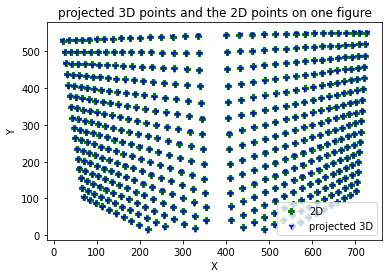

In [138]:
def visualisation(P, pts3d, pts2d):
    pts3d_extra_layer = np.hstack((pts3d, np.ones((pts3d.shape[0],1)))) # we need to add elements horizontally
    pts_project = np.dot(P, pts3d_extra_layer.T).T #calcualting the dot product
    # the 3D points projected with a matrix P ^
    normalised = pts_project[:,:2]/pts_project[:,2,np.newaxis]
    plt.scatter(pts2d[:,0], pts2d[:,1], c='g', marker='P', label='2D')
    plt.scatter(normalised[:,0], normalised[:,1], c='b', marker='1', label='projected 3D')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('projected 3D points and the 2D points on one figure')
    plt.legend()
    plt.show()
#calling the function
visualisation(P,pts3d,pts2d)
  

## 2. Camera parameters[50]

We want to extract the parameters of the camera from the matrix `P`, *i.e.*, the internal $(3\times 3)$ calibration matrix $\mathcal K$, the external $(3\times 3)$ rotation matrix $R$ and the $(3\times 1)$ translation vector $\mathbf t$ so that:

$$P=\mathcal K [R | \mathbf t]$$

To do so, we are going to use the formulas from the lectures, and the numpy functions (`np.linalg.norm`, `np.linalg.inv`, `np.dot`, `np.cross`...).

**5.a)** Write a function `camera_parameters(P, eps=1)` that takes as input the camera matrix `P` and a sign `eps` ($\varepsilon$, the sign of $\rho$ in the equations from the lecture), and outputs three values `K`, `R` and `t` that correspond to the intrinsic and extrinsic parameters of the camera.[30] <br/> 
**b)** Display the results for `eps=1` and check that your values `(K, R, t)` can correctly reconstruct `P`.[10]

In [270]:

import numpy as np

def camera_parameters(P, eps):
    # Decompose the projection matrix into A and b
    A = P[:, :3]
    b = P[:, 3]

    # Compute rho
    rho = eps / np.linalg.norm(A[2, :])

    # Compute r3
    r3 = rho * A[2, :]

    # Compute r1 and r2
    r1 = np.cross(A[1, :], A[2, :]) / np.linalg.norm(np.cross(A[1, :], A[2, :]))
    r2 = np.cross(r3, r1)

    # Compute the intrinsic matrix K
    K = np.dot(A, np.linalg.inv(np.vstack((r1, r2, r3))))

    # Compute the rotation matrix R
    R = np.vstack((r1, r2, r3))

    # Compute the translation vector t
    t =  np.linalg.inv(K) @ b
    
    # Reconstruct P
    recon_P = np.dot(K, np.hstack((R, t.reshape((-1, 1)))))


    return K, R, t, recon_P


**6.** The sign of $\rho$ is not easy to decide a priori: test your function with both choices of `eps`, and comment on which option makes more sense (is the object in front of the camera?)[10]

In [271]:
K1, R1, t1, recon_P = camera_parameters(P, eps=1) # makes more sense and gives positive values
# K1, R1, t1, recon_P = camera_parameters(P, eps=-1)

In [272]:
print("P:",P)
print("recon_P:",recon_P)

P: [[ 4.53359881e-03  5.65451256e-04 -2.02849590e-03  5.23179344e-01]
 [ 1.84278426e-03 -4.15975903e-03  1.68779276e-03  8.52192928e-01]
 [ 3.25683227e-06  1.13804182e-06  3.35237791e-06  1.43209220e-03]]
recon_P: [[ 4.53359881e-03  5.65451256e-04 -2.02849590e-03  5.23179344e-01]
 [ 1.84278426e-03 -4.15975903e-03  1.68779276e-03  8.52192928e-01]
 [ 3.25683227e-06  1.13804182e-06  3.35237791e-06  1.43209220e-03]]


In [273]:
# Normalize the matrices
P_norm = P / P[2, 3]
recon_P_norm = recon_P / recon_P[2, 3]

# Compare the matrices
print('Normalized P:', P_norm)
print('Normalized recon_P:', recon_P_norm)

Normalized P: [[ 3.16571712e+00  3.94842772e-01 -1.41645622e+00  3.65325182e+02]
 [ 1.28677766e+00 -2.90467263e+00  1.17855035e+00  5.95068478e+02]
 [ 2.27417778e-03  7.94670777e-04  2.34089530e-03  1.00000000e+00]]
Normalized recon_P: [[ 3.16571712e+00  3.94842772e-01 -1.41645622e+00  3.65325182e+02]
 [ 1.28677766e+00 -2.90467263e+00  1.17855035e+00  5.95068478e+02]
 [ 2.27417778e-03  7.94670777e-04  2.34089530e-03  1.00000000e+00]]


In [277]:
if np.allclose(P_norm, recon_P_norm):
    print("Yes")
else:
    print("No")


Yes
